In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from osgeo import gdal

In [27]:
files_to_mosaic = glob.glob('\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01*.tif')
files_to_mosaic

['\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000000000.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000023296.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000046592.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000069888.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000093184.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000116480.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000139776.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000163072.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000186368.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000209664.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\20

In [28]:
files_string = " ".join(files_to_mosaic)
print(files_string)

\users\marianne\documents\data\avhrr_ndvi_monthly\2015-01-0000000000-0000000000.tif \users\marianne\documents\data\avhrr_ndvi_monthly\2015-01-0000000000-0000023296.tif \users\marianne\documents\data\avhrr_ndvi_monthly\2015-01-0000000000-0000046592.tif \users\marianne\documents\data\avhrr_ndvi_monthly\2015-01-0000000000-0000069888.tif \users\marianne\documents\data\avhrr_ndvi_monthly\2015-01-0000000000-0000093184.tif \users\marianne\documents\data\avhrr_ndvi_monthly\2015-01-0000000000-0000116480.tif \users\marianne\documents\data\avhrr_ndvi_monthly\2015-01-0000000000-0000139776.tif \users\marianne\documents\data\avhrr_ndvi_monthly\2015-01-0000000000-0000163072.tif \users\marianne\documents\data\avhrr_ndvi_monthly\2015-01-0000000000-0000186368.tif \users\marianne\documents\data\avhrr_ndvi_monthly\2015-01-0000000000-0000209664.tif \users\marianne\documents\data\avhrr_ndvi_monthly\2015-01-0000000000-0000232960.tif \users\marianne\documents\data\avhrr_ndvi_monthly\2015-01-0000000000-0000256

In [35]:
os.chdir('\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly')
command = "gdal_merge.py -o \\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-all -of gtiff " + files_string
print(os.popen(command).read())

In [53]:
glob.glob('\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05*.tif')


['\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05-0000000000-0000000000.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05-0000000000-0000023296.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05-0000000000-0000046592.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05-0000000000-0000069888.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05-0000000000-0000093184.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05-0000000000-0000116480.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05-0000000000-0000139776.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05-0000000000-0000163072.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05-0000000000-0000186368.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05-0000000000-0000209664.tif',
 '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\20

In [34]:
command

'gdal_merge.py -o \\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-all -of gtiff \\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000000000.tif \\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000023296.tif \\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000046592.tif \\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000069888.tif \\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000093184.tif \\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000116480.tif \\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000139776.tif \\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000163072.tif \\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000186368.tif \\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-01-0000000000-0000209664.tif \\us

In [73]:
import rasterio
dataset = rasterio.open('\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05-0000046592-0000326144.tif')
raster = '\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2015-05-0000046592-0000326144.tif'
ds = gdal.Open(raster)

C:\Users\Marianne\anaconda3\envs\swe\lib\site-packages\matplotlib\image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
C:\Users\Marianne\anaconda3\envs\swe\lib\site-packages\matplotlib\image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\Marianne\anaconda3\envs\swe\lib\site-packages\matplotlib\image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)


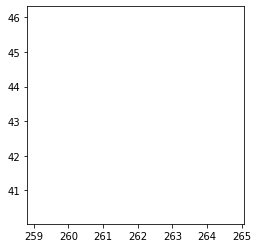

<AxesSubplot:>

In [41]:
import numpy as np
from rasterio.plot import show, adjust_band
show(dataset)  # factor 3 to increase brightness


In [63]:
import xarray as xr

In [112]:
data = xr.open_rasterio("\\users\\marianne\\documents\\data\\avhrr_ndvi_monthly\\2002-06-0000023296-0000209664.tif")
# show(data)

In [110]:
np.where(~np.isnan(data.values))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [121]:
print(data.to_numpy[:,1,1])

AttributeError: 'DataArray' object has no attribute 'to_numpy'